# Job Shop Scheduling Benchmarking Environment

This notebook introduces an open-source GitHub repository designed to benchmark and solve a wide range of machine scheduling problems, with a focus on job shop scheduling (JSP) and related problem types. Developed to address the long-standing need for a comprehensive testing environment, this resource supports various problem configurations, including classical Job Shops (JSP), Flow Shops (FSP), Flexible Job Shops (FJSP), Assembly scheduling with dependencies (FAJSP), and Flexible Job Shops with Sequence-Dependent Setup Times (FJSP-SDST).

This repository includes a diverse set of approaches, from traditional heuristics and meta-heuristics to exact solutions and advanced deep reinforcement learning techniques. With this environment, researchers, practitioners, and machine scheduling enthusiasts can experiment with and benchmark their methods, contributing to ongoing advancements in operations research and machine learning for scheduling applications.

Let’s start by importing the required packages:

In [1]:
import random

from visualization import gantt_chart, precedence_chart
from data.data_parsers.parser_fjsp import parse_fjsp
from scheduling_environment.jobShop import JobShop

from solution_methods.helper_functions import load_job_shop_env, load_parameters
from solution_methods.dispatching_rules.run_dispatching_rules import run_dispatching_rules
from solution_methods.GA.src.initialization import initialize_run
from solution_methods.GA.run_GA import run_GA
from solution_methods.MILP.run_MILP import run_MILP
from solution_methods.FJSP_DRL.run_FJSP_DRL import run_FJSP_DRL

#### Environment Configuration

We start by configuring the environment. For this, we provide a set of parsers that can be used to parse data files from various benchmarking instances from the literature to configure the JobShop environment. As many different sources of instances exist, the parsers parse the information from the data format into the data objectives from the benchmarking environment. You can find the parsers in the 'data_parsers' folder and can use them as follows:

##### Instance Parsing:

In [7]:
jobShopEnv = JobShop()
jobShopEnv = parse_fjsp(jobShopEnv, '/fjsp/brandimarte/Mk01.fjs')

In [15]:
print(jobShopEnv)

<JobShop(instance='/fjsp/brandimarte/Mk04.fjs', jobs=15, operations=90, machines=8)>


We also provide a 'helper function', that creates the JobShop() object, and selects based on the naming of the problem instance the right parser to be used:

In [8]:
jobShopEnv = load_job_shop_env('/fjsp/brandimarte/Mk01.fjs')

##### Instance inspection:

To inspect the instance we can plot it precedence relations:

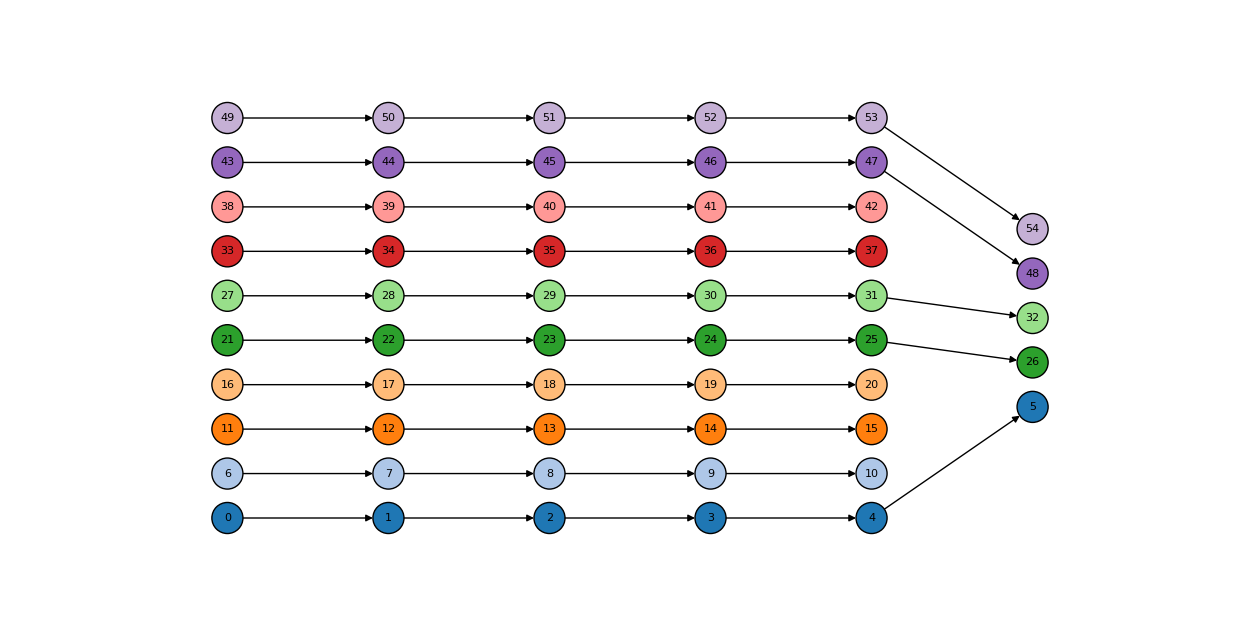

In [9]:
precedence_chart.plot(jobShopEnv)

##### Object ineractions:

We can now interact with the jobShopEnv to inspect its job, operation and machine objects, and make use of scheduling operators to schedule different operations within the environment. 

In [10]:
# Display the Job Shop Environment information
print('Job Shop Environment:')
print(jobShopEnv)

Job Shop Environment:
<JobShop(instance='/fjsp/brandimarte/Mk01.fjs', jobs=10, operations=55, machines=6)>


In [11]:
# Display the list of jobs in the environment
print('With the following Jobs:')
print(jobShopEnv.jobs)

With the following Jobs:
[<Job(job_id=0)>, <Job(job_id=1)>, <Job(job_id=2)>, <Job(job_id=3)>, <Job(job_id=4)>, <Job(job_id=5)>, <Job(job_id=6)>, <Job(job_id=7)>, <Job(job_id=8)>, <Job(job_id=9)>]


In [12]:
# Display the operations of the first job (job_id=0)
print('Where the first job (job_id=0) has the following operations:')
job = jobShopEnv.get_job(job_id=0)
print(job.operations)

Where the first job (job_id=0) has the following operations:
[<Operation(job_id=0, operation_id=0)>, <Operation(job_id=0, operation_id=1)>, <Operation(job_id=0, operation_id=2)>, <Operation(job_id=0, operation_id=3)>, <Operation(job_id=0, operation_id=4)>, <Operation(job_id=0, operation_id=5)>]


#### Starting to schedule

We show how to ineract with the scheduling environment by building a simple 'scheduler'. This scheduler select randomly an operation to be scheduled from the set of operations that are available for scheduling

In [13]:
jobShopEnv = load_job_shop_env('/fjsp/brandimarte/Mk04.fjs')
jobShopEnv.update_operations_available_for_scheduling()
while len(jobShopEnv.scheduled_operations) < jobShopEnv.nr_of_operations:
    operation = random.choice(jobShopEnv.operations_available_for_scheduling)
    machine_id = random.choice(list(operation.processing_times.keys()))
    duration = operation.processing_times[machine_id]
    jobShopEnv.schedule_operation_on_machine(operation, machine_id, duration)
    jobShopEnv.update_operations_available_for_scheduling()

The solution is generated with the jobShopEnv.schedule_operation_on_machine(operation, machine_id, duration) function. This function schedules an operation on the specified machine by adding it after the last operation that has already been scheduled on that machine.

Other functions to schedule operations are also provided, such as:

- jobShopEnv.schedule_operation_with_backfilling(operation, machine_id, duration)

This function schedules an operation at the earliest possible time with backfilling. It checks if there is an earlier gap in the schedule where the operation can be performed. If a suitable gap is found, the operation is scheduled to make use of unused time, resulting in a more efficient schedule. Backfilling allows the system to maximize machine utilization by filling in idle periods between operations.

- jobShopEnv.schedule_operation_on_machine_at_time(operation, machine_id, start_time, duration)

This function schedules an operation on a specified machine at a given start time. It ensures that the operation is placed at the exact time specified, taking into account any necessary setup times or constraints. This method provides more control over the scheduling process when a specific time is required for the operation to begin.

##### Plotting solution

After a schedule is obtained, we can pass the jobShopEnvironment to a plotting function, to plot the found solution:

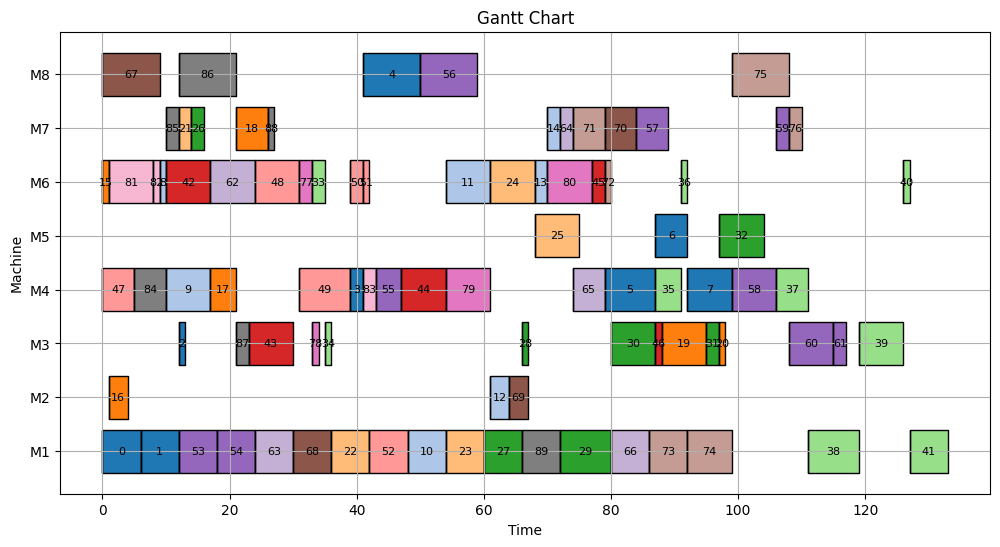

In [14]:
gantt_chart.plot(jobShopEnv);

### Solution Methods

The methods used to address variants of the Job Shop Scheduling Problem (JSP) can be broadly categorized into three main groups: 

- Exact Algorithms
- Heuristic Algorithms
- Machine Learning Approaches

In this project, we have implemented a variety of methods from each of these categories in a standardized way. This allows users to configure their problem environment and pass it to the appropriate solution method. Below, we provide a few examples demonstrating how the solution methods interact with the configured problem environments.

The parameters for different solution methods are specified in configuration files (.toml), which are located in the 'configs' directory. These files define the problem instance to be solved as well as the associated parameters for solving it. In the 'custom_problem_instance' tutorial, we show how these parameters can be included directly in the code, bypassing the need for a parameter .toml file.

#### Dispatching Rules

INFO:root:Makespan: 1823


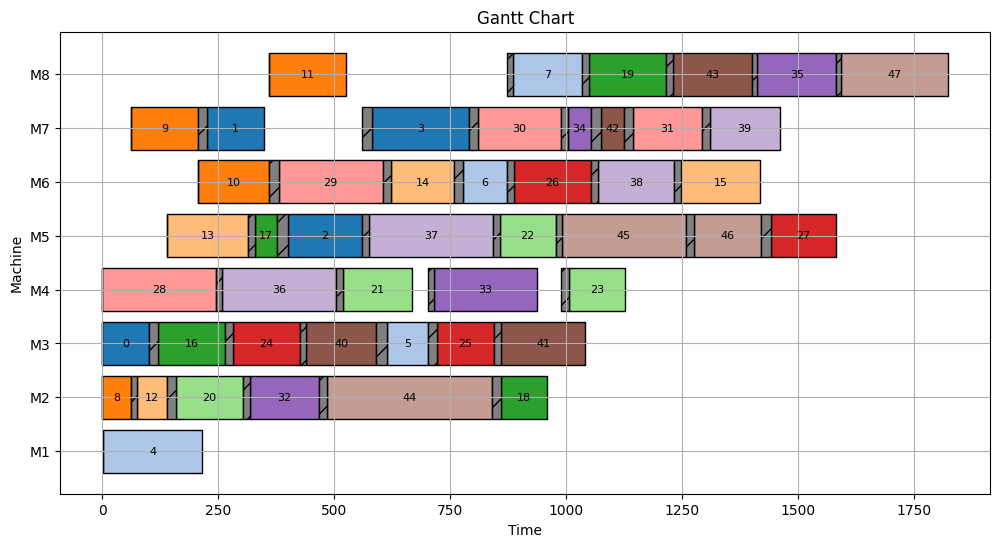

In [10]:
parameters = load_parameters("configs/dispatching_rules.toml")
jobShopEnv = load_job_shop_env(parameters['instance'].get('problem_instance'))

makespan, jobShopEnv = run_dispatching_rules(jobShopEnv, **parameters)
gantt_chart.plot(jobShopEnv);

#### Genetic Algorithm    

INFO:root:gen	avg    	std          	min   	max   
0  	[512.9]	[67.43656278]	[418.]	[642.]
INFO:root:
INFO:root:1  	[456.3]	[57.32198531]	[410.]	[563.]
INFO:root:2  	[416.8]	[11.89789897]	[399.]	[442.]
INFO:root:3  	[413.1]	[10.44461584]	[399.]	[428.]
INFO:root:4  	[404.9]	[9.71030381] 	[399.]	[428.]
INFO:root:5  	[399.] 	[0.]         	[399.]	[399.]
INFO:root:6  	[409.7]	[28.6218448] 	[374.]	[465.]
INFO:root:7  	[404.8]	[22.21170862]	[374.]	[465.]
INFO:root:8  	[399.1]	[11.88654702]	[374.]	[427.]
INFO:root:9  	[386.1]	[12.11981848]	[374.]	[399.]
INFO:root:10 	[387.6]	[14.58218091]	[374.]	[416.]
INFO:root:Makespan: 374


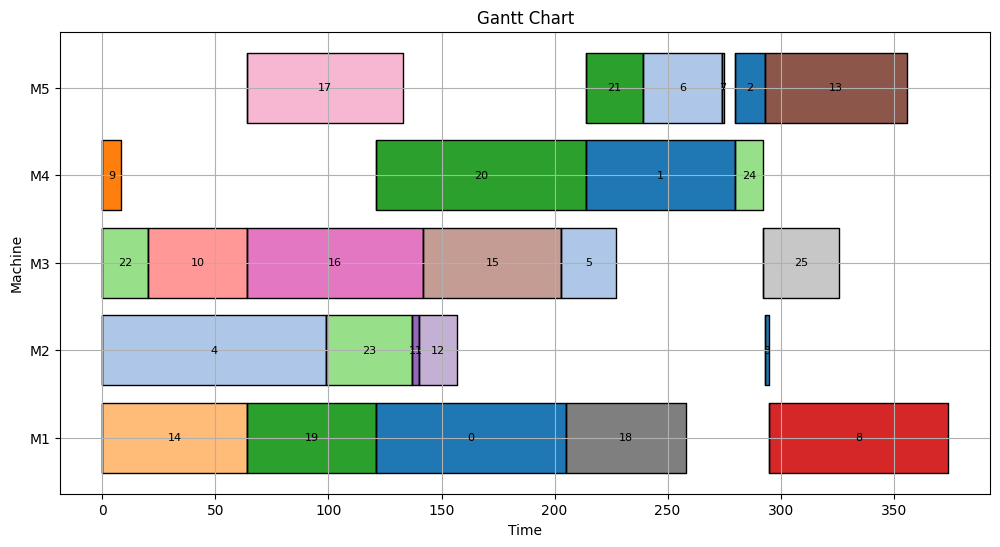

In [11]:
parameters = load_parameters("configs/GA.toml")
jobShopEnv = load_job_shop_env(parameters['instance'].get('problem_instance'))

population, toolbox, stats, hof = initialize_run(jobShopEnv, **parameters)
makespan, jobShopEnv = run_GA(jobShopEnv, population, toolbox, stats, hof, **parameters)

gantt_chart.plot(jobShopEnv);

#### Mixed-Interger Linear Programming

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-11-07


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-11-07


Set parameter TimeLimit to value 3600


INFO:gurobipy:Set parameter TimeLimit to value 3600


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 1360 rows, 1160 columns and 6706 nonzeros


INFO:gurobipy:Optimize a model with 1360 rows, 1160 columns and 6706 nonzeros


Model fingerprint: 0x45f066f2


INFO:gurobipy:Model fingerprint: 0x45f066f2


Variable types: 83 continuous, 1077 integer (1077 binary)


INFO:gurobipy:Variable types: 83 continuous, 1077 integer (1077 binary)


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 2e+03]


INFO:gurobipy:  Matrix range     [1e+00, 2e+03]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 5e+03]


INFO:gurobipy:  RHS range        [1e+00, 5e+03]


Presolve removed 17 rows and 705 columns


INFO:gurobipy:Presolve removed 17 rows and 705 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 1343 rows, 455 columns, 6540 nonzeros


INFO:gurobipy:Presolved: 1343 rows, 455 columns, 6540 nonzeros


Variable types: 83 continuous, 372 integer (372 binary)


INFO:gurobipy:Variable types: 83 continuous, 372 integer (372 binary)


Found heuristic solution: objective 842.0000000


INFO:gurobipy:Found heuristic solution: objective 842.0000000


Found heuristic solution: objective 829.0000000


INFO:gurobipy:Found heuristic solution: objective 829.0000000


Found heuristic solution: objective 569.0000000


INFO:gurobipy:Found heuristic solution: objective 569.0000000


Found heuristic solution: objective 567.0000000


INFO:gurobipy:Found heuristic solution: objective 567.0000000


INFO:gurobipy:


Root relaxation: objective 2.440000e+02, 123 iterations, 0.00 seconds (0.00 work units)


INFO:gurobipy:Root relaxation: objective 2.440000e+02, 123 iterations, 0.00 seconds (0.00 work units)


INFO:gurobipy:


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


     0     0  244.00000    0   10  567.00000  244.00000  57.0%     -    0s


INFO:gurobipy:     0     0  244.00000    0   10  567.00000  244.00000  57.0%     -    0s


H    0     0                     315.0000000  244.00000  22.5%     -    0s


INFO:gurobipy:H    0     0                     315.0000000  244.00000  22.5%     -    0s


H    0     0                     298.0000000  244.00000  18.1%     -    0s


INFO:gurobipy:H    0     0                     298.0000000  244.00000  18.1%     -    0s


     0     0  244.00000    0   22  298.00000  244.00000  18.1%     -    0s


INFO:gurobipy:     0     0  244.00000    0   22  298.00000  244.00000  18.1%     -    0s


     0     0  244.00000    0   22  298.00000  244.00000  18.1%     -    0s


INFO:gurobipy:     0     0  244.00000    0   22  298.00000  244.00000  18.1%     -    0s


     0     0  244.00000    0    8  298.00000  244.00000  18.1%     -    0s


INFO:gurobipy:     0     0  244.00000    0    8  298.00000  244.00000  18.1%     -    0s


     0     0  244.00000    0   11  298.00000  244.00000  18.1%     -    0s


INFO:gurobipy:     0     0  244.00000    0   11  298.00000  244.00000  18.1%     -    0s


     0     0  244.00000    0   14  298.00000  244.00000  18.1%     -    0s


INFO:gurobipy:     0     0  244.00000    0   14  298.00000  244.00000  18.1%     -    0s


     0     0  244.00000    0   13  298.00000  244.00000  18.1%     -    0s


INFO:gurobipy:     0     0  244.00000    0   13  298.00000  244.00000  18.1%     -    0s


     0     0  244.00000    0   13  298.00000  244.00000  18.1%     -    0s


INFO:gurobipy:     0     0  244.00000    0   13  298.00000  244.00000  18.1%     -    0s


     0     0  244.00000    0   14  298.00000  244.00000  18.1%     -    0s


INFO:gurobipy:     0     0  244.00000    0   14  298.00000  244.00000  18.1%     -    0s


     0     0  244.00000    0    9  298.00000  244.00000  18.1%     -    0s


INFO:gurobipy:     0     0  244.00000    0    9  298.00000  244.00000  18.1%     -    0s


     0     0  244.00000    0    6  298.00000  244.00000  18.1%     -    0s


INFO:gurobipy:     0     0  244.00000    0    6  298.00000  244.00000  18.1%     -    0s


     0     0  244.00000    0   10  298.00000  244.00000  18.1%     -    0s


INFO:gurobipy:     0     0  244.00000    0   10  298.00000  244.00000  18.1%     -    0s


     0     0  244.00000    0   10  298.00000  244.00000  18.1%     -    0s


INFO:gurobipy:     0     0  244.00000    0   10  298.00000  244.00000  18.1%     -    0s


     0     2  244.00000    0    9  298.00000  244.00000  18.1%     -    0s


INFO:gurobipy:     0     2  244.00000    0    9  298.00000  244.00000  18.1%     -    0s


*  371   300              56     293.0000000  244.00000  16.7%   8.8    0s


INFO:gurobipy:*  371   300              56     293.0000000  244.00000  16.7%   8.8    0s


*  435   347              55     291.0000000  244.00000  16.2%   8.5    0s


INFO:gurobipy:*  435   347              55     291.0000000  244.00000  16.2%   8.5    0s


H  476   401                     283.0000000  244.00000  13.8%   8.4    0s


INFO:gurobipy:H  476   401                     283.0000000  244.00000  13.8%   8.4    0s


H  511   401                     274.0000000  244.00000  10.9%   8.3    0s


INFO:gurobipy:H  511   401                     274.0000000  244.00000  10.9%   8.3    0s


H  787   425                     267.0000000  244.00000  8.61%   7.9    0s


INFO:gurobipy:H  787   425                     267.0000000  244.00000  8.61%   7.9    0s


H 2211   830                     266.0000000  244.00000  8.27%   7.3    1s


INFO:gurobipy:H 2211   830                     266.0000000  244.00000  8.27%   7.3    1s


H 2215   791                     262.0000000  244.00000  6.87%   7.3    1s


INFO:gurobipy:H 2215   791                     262.0000000  244.00000  6.87%   7.3    1s


H 2600   774                     258.0000000  248.00000  3.88%   9.8    1s


INFO:gurobipy:H 2600   774                     258.0000000  248.00000  3.88%   9.8    1s


* 3835   433              48     257.0000000  255.00000  0.78%  10.4    2s


INFO:gurobipy:* 3835   433              48     257.0000000  255.00000  0.78%  10.4    2s


INFO:gurobipy:


Cutting planes:


INFO:gurobipy:Cutting planes:


  Learned: 2


INFO:gurobipy:  Learned: 2


  Gomory: 4


INFO:gurobipy:  Gomory: 4


  Cover: 2


INFO:gurobipy:  Cover: 2


  Implied bound: 1


INFO:gurobipy:  Implied bound: 1


  MIR: 12


INFO:gurobipy:  MIR: 12


  Flow cover: 11


INFO:gurobipy:  Flow cover: 11


  GUB cover: 1


INFO:gurobipy:  GUB cover: 1


  RLT: 3


INFO:gurobipy:  RLT: 3


INFO:gurobipy:


Explored 10209 nodes (114779 simplex iterations) in 3.02 seconds (1.82 work units)


INFO:gurobipy:Explored 10209 nodes (114779 simplex iterations) in 3.02 seconds (1.82 work units)


Thread count was 12 (of 12 available processors)


INFO:gurobipy:Thread count was 12 (of 12 available processors)


INFO:gurobipy:


Solution count 10: 257 258 262 ... 298


INFO:gurobipy:Solution count 10: 257 258 262 ... 298


INFO:gurobipy:


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Best objective 2.570000000000e+02, best bound 2.570000000000e+02, gap 0.0000%


INFO:gurobipy:Best objective 2.570000000000e+02, best bound 2.570000000000e+02, gap 0.0000%


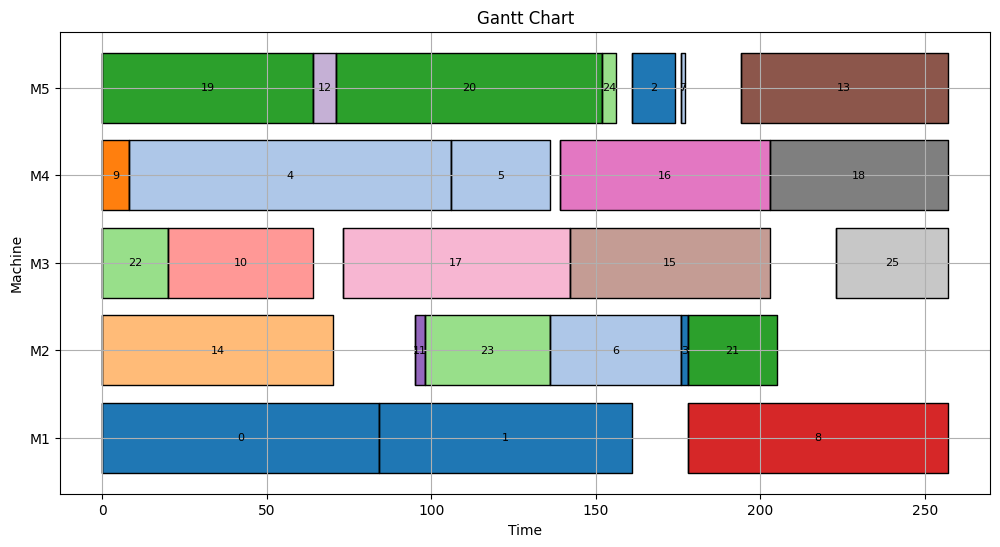

In [12]:
parameters = load_parameters("configs/milp.toml")
jobShopEnv = load_job_shop_env(parameters['instance'].get('problem_instance'))

results, jobShopEnv = run_MILP(jobShopEnv, **parameters)
gantt_chart.plot(jobShopEnv);

#### FJSP_DRL

INFO:root:Trained policy loaded from /saved_models/train_20240314_192906/song_10_5.pt.


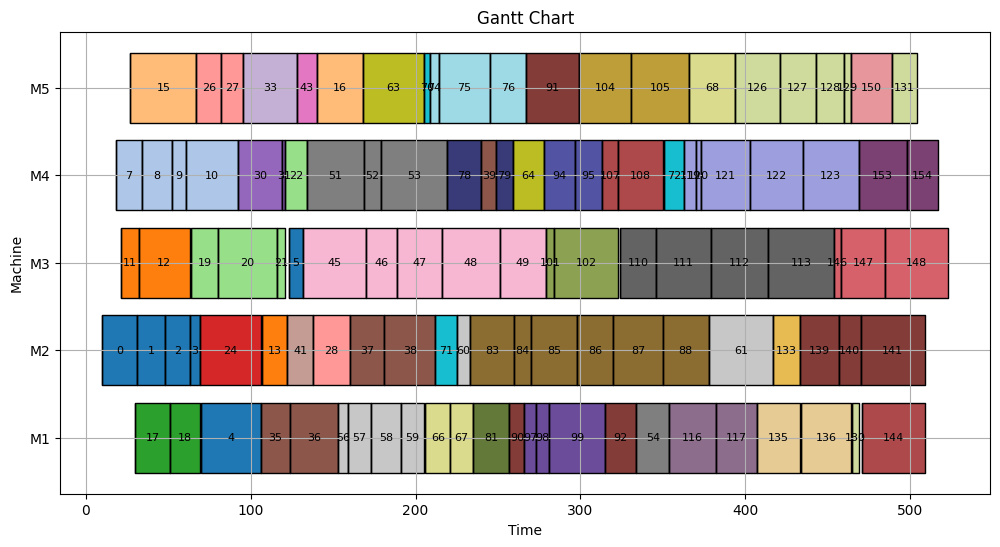

In [13]:
parameters = load_parameters("configs/fjsp_drl.toml")
jobShopEnv = load_job_shop_env(parameters['test_parameters'].get('problem_instance'))

makespan, jobShopEnv = run_FJSP_DRL(jobShopEnv, **parameters)
gantt_chart.plot(jobShopEnv);